In [41]:
import pandas as pd
import numpy as np
import math

from saturation.simulation import *
from saturation.distributions import *
from saturation.geometry import *
from saturation.areal_density import *

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio

In [284]:
data = pd.read_csv("data/Dione_reg1-sub.csv")
data = data.rename({"Diameter:double": "d"}, axis=1)

In [285]:
data

,longitude,latitude,d
0,233.37000,-26.77000,20380.024240
1,210.56000,-46.29000,20038.071640
2,237.50999,-47.86000,17844.648980
3,205.03999,-35.39000,15376.213600
4,207.62000,-46.39000,15351.962300
...,...,...,...
60,255.25000,-41.27000,4116.000000
61,221.00999,-29.04000,4020.551600
62,207.25000,-40.51000,4005.566724
63,215.31235,-26.23246,21256.495028


In [286]:
data.describe()

,longitude,latitude,d
count,65.000000,65.000000,65.000000
mean,230.824991,-38.474824,7735.949291
std,18.183547,7.556247,4463.778127
min,203.810000,-60.940000,4005.566724
25%,213.840000,-43.860000,4746.227622
50%,231.370000,-37.440000,5540.056816
75%,246.420000,-32.490000,9205.847600
max,271.310000,-26.232460,21256.495028


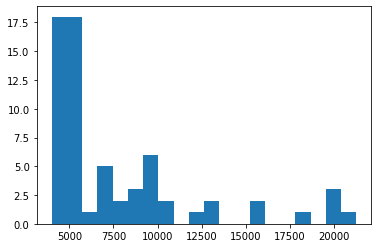

In [287]:
plt.hist(data.d, bins=20)
plt.show()

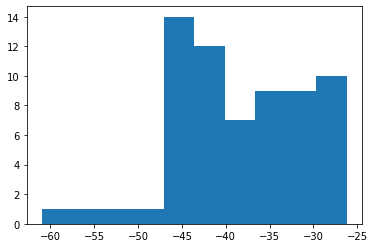

In [288]:
plt.hist(data.latitude)
plt.show()

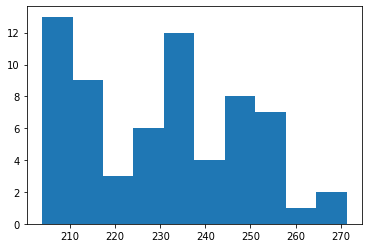

In [289]:
plt.hist(data.longitude)
plt.show()

In [290]:
def rotation_matrix(axis: List[float], theta: float):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def rotate_points(p: List[float],
                  axis: List[float],
                  theta: float) -> np.array:
    return np.matmul(np.array(p), rotation_matrix(axis, theta))

In [291]:
# Testing the math
p = [[3, 5, 5],
     [4, 0, 5],
     [1, 1, 2]
    ]
axis = [1, 0, 0]
theta1 = -np.arctan(p[0][2] / p[0][1])

rotate_points(p, axis, theta1)

array([[ 3.00000000e+00, -5.55111512e-16,  7.07106781e+00],
       [ 4.00000000e+00, -3.53553391e+00,  3.53553391e+00],
       [ 1.00000000e+00, -7.07106781e-01,  2.12132034e+00]])

In [292]:
# Testing the math
# Trying to rotate the first point to 0, 0, 0
p = np.array([
     [3, 5, 6],
     [4, 3, 5],
     [1, 1, -2]
    ])
index = 2
theta1 = -(math.pi / 2 - np.arctan(p[index][2] / p[index][1]))

p = rotate_points(p, [1, 0, 0], theta1)

theta2 = -np.arctan(p[index][2] / p[index][0])
p = rotate_points(p, [0, 1, 0], theta2)
p

array([[-1.63299316e+00, -7.15541753e+00, -4.01663209e+00],
       [-1.22474487e+00, -4.91934955e+00, -4.92950302e+00],
       [ 2.44948974e+00,  3.33066907e-16, -1.23804119e-16]])

In [293]:
p = np.array([
     [3, 5, 5],
     [4, 0, 5],
     [1, 1, 2]
    ])
np.linalg.norm(p[index])

2.449489742783178

In [294]:
# Area of regions 1-4 in km^2, provided by Dr. Kirchoff
# Assuming this is the area of the sub-region
# 102449, 62647, 53552, 38712

In [295]:
# Convert from lat/long to x, y, z
dione_radius_km = 561.4

lat = np.deg2rad(data.latitude)
long = np.deg2rad(data.longitude)

data["x"] = dione_radius_km * np.cos(lat) * np.cos(long)
data["y"] = dione_radius_km * np.cos(lat) * np.sin(long)
data["z"] = dione_radius_km * np.sin(lat)

In [296]:
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics.pairwise import euclidean_distances

subset = data

lat_long_rad = np.deg2rad(subset[["latitude", "longitude"]])
hav_dists = haversine_distances(lat_long_rad, lat_long_rad) * dione_radius_km

euc_dists = euclidean_distances(subset[["x", "y", "z"]], subset[["x", "y", "z"]])

In [297]:
abs(hav_dists - euc_dists).mean()

1.7024860727543774

In [298]:
coordinates = data[["x", "y", "z"]].values
medians_initial = np.median(coordinates, axis=0)
medians = np.median(coordinates, axis=0)
theta = -(math.pi / 2 - np.arctan(medians[2] / medians[1]))
p = rotate_points(coordinates, [1, 0, 0], theta)
medians = rotate_points([medians], [1, 0, 0], theta)[0]

theta = -np.arctan(medians[2] / medians[0])
result = rotate_points(p, [0, 1, 0], theta)

In [299]:
hover_data = {
    "latitude": ":.3f",
    "longitude": ":.3f",
}

fig = px.scatter_3d(
    data,
    x="x",
    y="y",
    z="z",
    color="latitude",
    hover_data=hover_data,
    width=500,
    height=500
)
fig.show()

In [300]:
# Try haversine distances to calc area of the region as a checksum

In [301]:
pd.DataFrame(result).describe()

,0,1,2
count,65.000000,65.000000,65.000000
mean,-540.952546,4.558212,-11.369986
std,16.778629,82.479857,125.122531
min,-561.140780,-156.829653,-282.596295
25%,-553.513851,-59.742132,-115.832640
50%,-542.720557,-0.252709,-7.306396
75%,-534.386987,64.198072,95.095007
max,-465.070915,168.180145,186.414803


In [302]:
data["x_converted"] = result[:, 1]
data["y_converted"] = result[:, 2]
data["z_converted"] = result[:, 0]

In [303]:
data.describe()

,longitude,latitude,d,x,y,z,x_converted,y_converted,z_converted
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,230.824991,-38.474824,7735.949291,-265.812804,-319.740498,-346.250311,4.558212,-11.369986,-540.952546
std,18.183547,7.556247,4463.778127,111.323169,84.522573,56.596675,82.479857,125.122531,16.778629
min,203.810000,-60.940000,4005.566724,-429.264718,-449.182869,-490.726216,-156.829653,-282.596295,-561.140780
25%,213.840000,-43.860000,4746.227622,-356.273385,-398.920619,-388.993285,-59.742132,-115.832640,-553.513851
50%,231.370000,-37.440000,5540.056816,-277.535105,-321.332850,-341.292069,-0.252709,-7.306396,-542.720557
75%,246.420000,-32.490000,9205.847600,-178.311472,-247.457867,-301.557358,64.198072,95.095007,-534.386987
max,271.310000,-26.232460,21256.495028,6.234102,-155.263173,-248.146721,168.180145,186.414803,-465.070915


In [304]:
x_size_km = (data.x_converted.max() - data.x_converted.min())
y_size_km = (data.y_converted.max() - data.y_converted.min())
x_size_km * y_size_km

152433.2018743673

In [305]:
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics.pairwise import euclidean_distances

subset = data

lat_long_rad = np.deg2rad(subset[["latitude", "longitude"]])
hav_dists = haversine_distances(lat_long_rad, lat_long_rad) * dione_radius_km

euc_dists = euclidean_distances(subset[["x_converted", "y_converted"]], subset[["x_converted", "y_converted"]])

In [306]:
abs(hav_dists - euc_dists).mean()

2.9696174379768334

In [307]:
# Finding bounding area
min_lat = np.deg2rad(data.latitude.min())
max_lat = np.deg2rad(data.latitude.max())

min_long = np.deg2rad(data.longitude.min())
max_long = np.deg2rad(data.longitude.max())

side1 = haversine_distances([[min_lat, min_long]], [[max_lat, min_long]]) * dione_radius_km
side2 = haversine_distances([[min_lat, min_long]], [[min_lat, max_long]]) * dione_radius_km

In [308]:
side1 * side2

array([[104333.39330334]])

In [309]:
fig = px.scatter_3d(
    data,
    x="x_converted",
    y="y_converted",
    z="z_converted",
    width=500,
    height=500
)
fig.show()

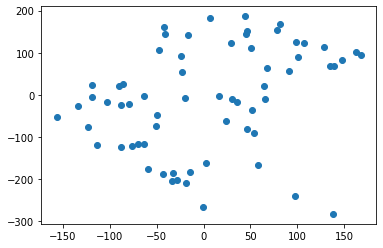

In [310]:
plt.scatter(data.x_converted, data.y_converted)

### Calculate areal density

In [600]:
data["x"] = data.x * 1000
data["y"] = data.y * 1000
data["r"] = data.d / 2

In [601]:
data

,longitude,latitude,d,z,y,x,r
0,187.09000,-15.64,11993.510790,-536.480128,-66727.048306,-151349.043872,5996.755395
1,198.25000,-15.27,8176.053123,-514.338077,-169603.262313,-147854.779893,4088.026561
2,190.25000,-15.20,22582.112330,-533.114144,-96402.741461,-147193.004889,11291.056165
3,198.77000,-15.01,5067.715359,-513.407625,-174478.292180,-145395.653809,2533.857679
4,185.60001,-14.94,7899.051475,-539.833845,-52931.266411,-144733.067743,3949.525738
...,...,...,...,...,...,...,...
294,190.00000,11.54,5458.626133,-541.694939,-95515.433064,112309.194079,2729.313066
295,191.42000,11.91,6699.588607,-538.439464,-108764.046293,115858.904953,3349.794303
296,190.25000,12.38,2130.464944,-539.594647,-97574.607254,120361.011193,1065.232472
297,191.86000,12.52,7971.775868,-536.350742,-112635.814697,121700.512260,3985.887934


In [602]:
x_range = data.x.max() - data.x.min()
y_range = data.y.max() - data.y.min()

# Scale the larger dimension of x and y to (0, 10000)
scale_range = x_range if x_range > y_range else y_range
pixels_per_meter = scale_range / 10000

In [603]:
data["x_scaled"] = (data.x - data.x.min()) / pixels_per_meter
data["y_scaled"] = (data.y - data.y.min()) / pixels_per_meter
data["r_scaled"] = data.r / pixels_per_meter

In [604]:
data.x_scaled.describe()

count      299.000000
mean      4526.945350
std       2426.999049
min          0.000000
25%       2647.479527
50%       4450.351736
75%       6557.753090
max      10000.000000
Name: x_scaled, dtype: float64

In [605]:
data.y_scaled.describe()

count     299.000000
mean     3428.359676
std      1895.650701
min         0.000000
25%      1847.721836
50%      3414.216803
75%      4835.680081
max      7397.398428
Name: y_scaled, dtype: float64

In [606]:
data.r_scaled.describe()

count    299.000000
mean     120.669946
std       84.935248
min       30.642420
25%       61.260944
50%      101.579497
75%      150.243700
max      612.016900
Name: r_scaled, dtype: float64

In [607]:
calculator = ArealDensityCalculator((math.ceil(data.x_scaled.max()), math.ceil(data.y_scaled.max())),
                                    (0, 0),
                                    0)

In [608]:
for idx, row in enumerate(data.itertuples()):
    crater = Crater(id=idx,
                    x=row.x_scaled,
                    y=row.y_scaled,
                    radius=row.r_scaled,
                   )
    calculator.add_crater(crater)

In [609]:
calculator.areal_density

0.25075278810408924